# Trayendo datos de poloniex y convirtiendolos en dataframe

In [10]:
import pandas as pd
import pylab as plt
from tusp import string2ts, ts2string
from bot import prepareData,marketReturn
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 8

# trayendo y preparando datos
df  = prepareData(pair="BTC_XRP",
                  start=string2ts("2017-07-01 00:00:00"),
                  end=string2ts("2018-02-01 00:00:00"),
                  period=3600*4)
"""
# calculando el retorno del mercado hasta el 4 quitil y del ultimo quintil
df_train = df.loc["2014-09-10 00:00:00":"2017-06-01 00:00:00",:]
df_test = df.loc["2017-06-01 00:00:00":"2017-09-01 00:00:00",:]
"""
per = 0.9
cum_return1 = marketReturn(df[:int(len(df)*per)]["close"])
cum_return2 = marketReturn(df[int(len(df)*per):]["close"]) 
#cum_return1 = marketReturn(df_train)
#cum_return2 = marketReturn(df_test) 

marketReturn = cum_return1[-1]*100 
marketReturn2 = cum_return2[-1]*100

print "Retorno final del mercado: %s"%(marketReturn)
df.head()

Retorno final del mercado: 35.0372208437


,close,high,low,open,quoteVolume,volume,weightedAverage,volatility
date,,,,,,,,
2017-07-01 00:00:00,0.000101,0.000101,0.000099,0.000101,6804554.152342,682.629027,0.000100,False
2017-07-01 04:00:00,0.000099,0.000101,0.000099,0.000101,7776308.3545149,778.744184,0.000100,True
2017-07-01 08:00:00,0.000099,0.000101,0.000099,0.000099,4414968.642775,439.684562,0.000100,False
2017-07-01 12:00:00,0.000100,0.000100,0.000099,0.000099,5629641.7432203,559.404665,0.000099,False
2017-07-01 16:00:00,0.000099,0.000100,0.000098,0.000100,5427761.1629749,537.959577,0.000099,True


# Creando estrategias, columna con RSI_14 y sus respectivos vectores de peso

Retorno del mercacdo: 35.0372208437
Retorno de SMA13 VS EMA5: 455.164521435
Retorno de Precio VS SMA20: 452.550161551
Retorno de Precio VS EMA5: 721.782876768


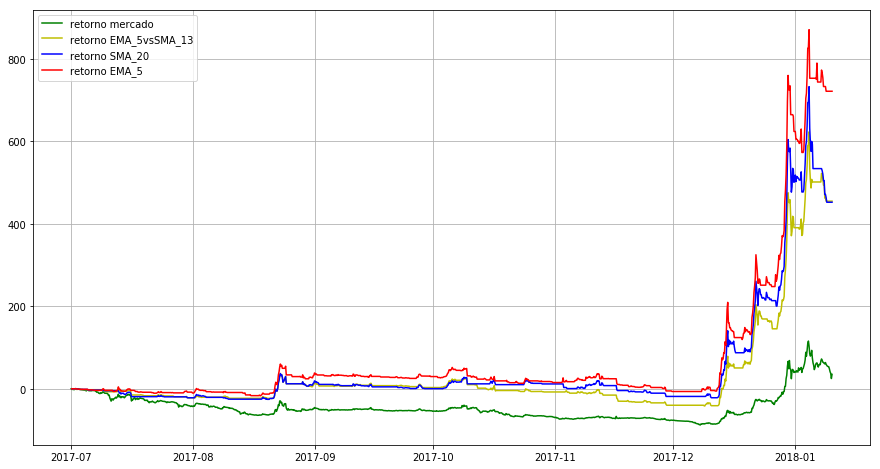

In [11]:
from strategy2 import EMAvsSMA,pricevsEMA, pricevsSMA
from profit import profit

#EMA_5vsSMA_13
w = EMAvsSMA(df['weightedAverage'],13,5)
wTrain = w[:int(len(df)*per)]
wTest = w[int(len(df)*per):]
relativeReturn,v = profit(wTrain)
relativeReturnTest,vTest = profit(wTest)

#Precio vs SMA_20
w3 = pricevsSMA(df['weightedAverage'],20)
w3Train = w3[:int(len(df)*per)]
w3Test = w3[int(len(df)*per):]
relativeReturn3,v3 = profit(w3Train)
relativeReturn3Test,v3Test = profit(w3Test)

#Precio vs EMA_5
# 23.6
w2 = pricevsEMA(df['weightedAverage'])
w2Train = w2[:int(len(df)*per)]
w2Test = w2[int(len(df)*per):]
relativeReturn2,v2 = profit(w2Train)
relativeReturn2Test,v2Test = profit(w2Test)

print 'Retorno del mercacdo: %s'%(marketReturn)
print 'Retorno de SMA13 VS EMA5: %s'%(relativeReturn*100)
print 'Retorno de Precio VS SMA20: %s'%(relativeReturn3*100)
print 'Retorno de Precio VS EMA5: %s'%(relativeReturn2*100)

plt.plot(df.index[:int(len(df)*per)],cum_return1*100,'g', label='retorno mercado')
plt.plot(df.index[:int(len(df)*per)],v*100,'y',label='retorno EMA_5vsSMA_13')
plt.plot(df.index[:int(len(df)*per)],v3*100,'b',label='retorno SMA_20')
plt.plot(df.index[:int(len(df)*per)],v2*100,'r',label='retorno EMA_5')

plt.legend(loc='best')
plt.grid()


## RSI via stockstacks

In [12]:
from stockstats import StockDataFrame

stock = StockDataFrame.retype(df.copy())
stock["rsi_14"];
stock["macd"];
stock["macds"];
stock["cci"];
stock["wr_14"];

In [13]:
from peakdetect import peakdetect

y = df['close'].values
x = df.index[:].values

_max, _min = peakdetect(y, x, 3)

xm = [p[0] for p in _max]
ym = [p[1] for p in _max]
xn = [p[0] for p in _min]
yn = [p[1] for p in _min]




## Indicadores via TA-Lib

In [14]:
#import talib

#df["fastk"], df["fastd"] = talib.STOCHRSI(df["close"].values, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)

#plt.subplot(211)
#plot = plt.plot(x, y)
#plt.hold(True)
#plt.plot(xm, ym, "r+")
#plt.plot(xn, yn, "g+")
#plt.subplot(212)
#df["fastk"].plot()
#df["fastd"].plot()

# Preparando DataFrame para ML

## Creando estrategia ideal en base a maximos y minimos

In [15]:
from mldata import ml_data
from orders import orders

hopes = range(1,21)
trains = []
tests = []

for i in hopes:
    
    df["ml_data"] = ml_data(df["close"], False, i)

    w4 = pd.DataFrame(data={"w":df["ml_data"].values,"price":df["close"]})
    w4["orders"] = orders(w4["w"])
    w4["w"] = w4["w"].shift(1)

    data = pd.DataFrame(data={"price":df["close"],"pricew":df["weightedAverage"],"volumen":df["volume"],
                              "rsi":stock["rsi_14"],"macd":stock["macd"],"macds":stock["macds"],"cci":stock["cci"],
                              "wr":stock["wr_14"] ,"sma13ema5":w["w"],"price_sma20":w3["w"],"price_ema5":w2["w"],
                              "ideal_w":w4["w"],"volatility": df["volatility"],"close":df["close"]})

    # separando datos para crear y evaluar el modelo de machine learning
    train = data[1:int(len(data)*per)]
    test = data[int(len(data)*per):]
    
    trains.append(train)
    tests.append(test)

print len(trains), len(tests)
"""
w4 = pd.DataFrame(data={"w":df["ml_data"].values,"price":df["close"]})
w4["orders"] = orders(w4["w"])
w4["w"] = w4["w"].shift(1)
relReturn, vecReturn4 = profit(w4)
print "Retorno de estrategia ideal: %s"%(relReturn*100)
"""

#train = data.loc["2014-09-10 00:00:00":"2017-06-01 00:00:00",:][1:]
#test = data.loc["2017-06-01 00:00:00":"2017-09-01 00:00:00",:]
#print len(train),len(test)

20 20


'\nw4 = pd.DataFrame(data={"w":df["ml_data"].values,"price":df["close"]})\nw4["orders"] = orders(w4["w"])\nw4["w"] = w4["w"].shift(1)\nrelReturn, vecReturn4 = profit(w4)\nprint "Retorno de estrategia ideal: %s"%(relReturn*100)\n'

# Encontrando mejor hope (detección de picos)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Graficando resultados


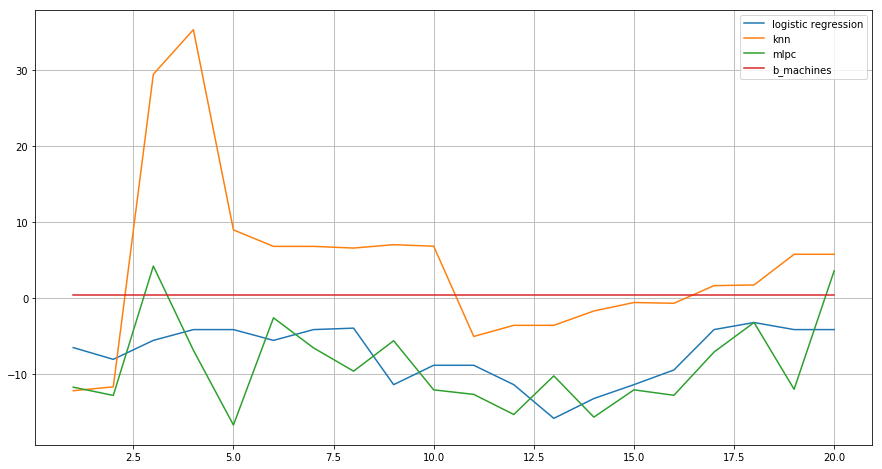

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
# Estas dos últimas librerías permiten la creación de una 
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
# "price","volumen","rsi","macd","macds","sma13ema5","price_sma20","price_ema5","ideal_w","cci","diff","wr"
features = ["price","rsi","cci"]

logregs = []
knns = []
mlpcs = []
b_machines = []

for i in range(len(hopes)):
    
    print i
    train = trains[i]
    test = tests[i]
    
    # regresion logistica

    #print "En logistic regression..."
    logreg = LogisticRegression()
    logreg.fit(train[features],train["ideal_w"])
    w_pred = logreg.predict(test[features])
    w5 = pd.DataFrame(data={"w":w_pred,"price":test["close"]})
    w5["orders"] = orders(w5["w"])
    w5["w"] = w5["w"].shift(1)
    relativeReturn5, v5 = profit(w5)
    logregs.append(relativeReturn5*100)

    # knn
    
    #print "En knn..."
    knn = KNeighborsClassifier(n_neighbors = 30)
    knn.fit(train[features],train["ideal_w"])
    w_pred3 = knn.predict(test[features])
    w7 = pd.DataFrame(data={"w":w_pred3,"price":test["close"]})
    w7["orders"] = orders(w7["w"])
    w7["w"] = w7["w"].shift(1)
    relativeReturn7, v7 = profit(w7)
    knns.append(relativeReturn7*100)
    
    
    # Neural network
    # MLPClassifier
    
    #print "En mlpc"
    mlpc = MLPClassifier(hidden_layer_sizes = (100,))
    mlpc.fit(train[features],train["ideal_w"])
    w_pred4 = mlpc.predict(test[features])
    w8 = pd.DataFrame(data={"w":w_pred4,"price":test["close"]})
    w8["orders"] = orders(w8["w"])
    w8["w"] = w8["w"].shift(1)
    relativeReturn8, v8 = profit(w8)
    mlpcs.append(relativeReturn8*100)
    
    
    # Boltzman deep learning machine
    
    #print "En boltzman deep learning machine"
    rbm = BernoulliRBM()
    logistic = LogisticRegression()
    classifier = Pipeline([("rbm",rbm),("logistic",logistic)])
    classifier.fit(train[features],train["ideal_w"])
    w_pred5 = classifier.predict(test[features])
    w9 = pd.DataFrame(data={"w":w_pred5,"price":test["close"]})
    w9["orders"] = orders(w9["w"])
    w9["w"] = w9["w"].shift(1)
    relativeReturn9, v9 = profit(w9)
    b_machines.append(relativeReturn9*100)


print "Graficando resultados"


plt.plot(hopes, logregs, label='logistic regression')
plt.plot(hopes, knns, label='knn')
plt.plot(hopes, mlpcs, label='mlpc')
plt.plot(hopes, b_machines, label='b_machines')
plt.legend(loc='best')
plt.grid()

Graficando resultados


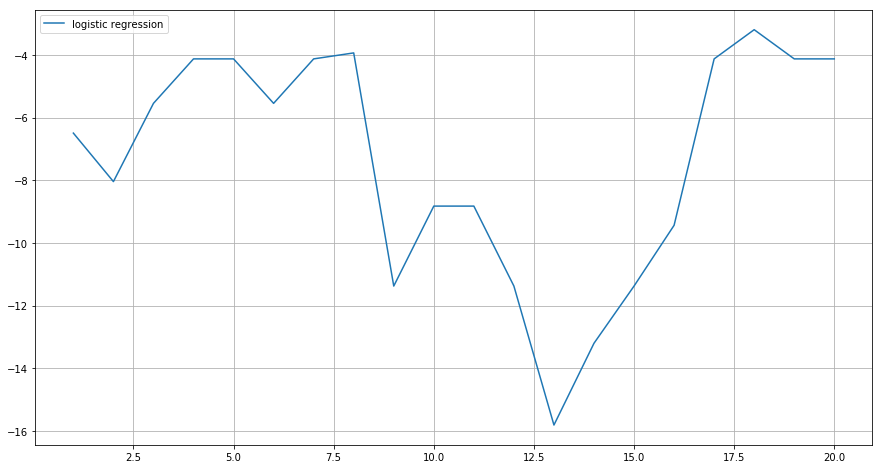

In [17]:
print "Graficando resultados"

plt.plot(hopes, logregs, label='logistic regression')
#plt.plot(hopes, knns, label='knn')
#plt.plot(hopes, mlpcs, label='mlpc')
#plt.plot(hopes, b_machines, label='b_machines')
plt.legend(loc='best')
plt.grid()

In [18]:
logregs

[-6.4965443349629615,
 -8.0444866520730898,
 -5.5467342290195791,
 -4.1273545521331449,
 -4.1273545521331449,
 -5.5467342290195791,
 -4.1273545521331449,
 -3.9365286949130773,
 -11.378991218560985,
 -8.8264565290109847,
 -8.8264565290109847,
 -11.378991218560985,
 -15.815002053134918,
 -13.204765899366045,
 -11.378991218560985,
 -9.4393772939070697,
 -4.1273545521331449,
 -3.1952583017110348,
 -4.1273545521331449,
 -4.1273545521331449]